# RF Jamming Detection with Lightweight 2D CNN

This notebook demonstrates the complete workflow of the RF jamming detection system from data analysis to model training and evaluation.

## Table of Contents
1. [Data Loading and Analysis](#data-analysis)
2. [Data Preprocessing](#preprocessing) 
3. [Model Training](#training)
4. [Model Evaluation](#evaluation)
5. [Real-time Demo](#demo)

## Project Overview
- **Model**: Lightweight 2D CNN (99.6% accuracy on independent test data)
- **Data**: RSSI signals from Normal, Constant Jammer, and Periodic Jammer scenarios
- **Features**: Mel spectrograms (64x8x1) derived from RSSI time series
- **Architecture**: 119,747 parameters, optimized for production deployment

## Environment Setup

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os
import sys
from pathlib import Path

# Add scripts directory to path to import our modules
scripts_path = Path('../scripts').resolve()
sys.path.append(str(scripts_path))

# Set random seeds for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('default')
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['figure.dpi'] = 100

# Change to project root directory
os.chdir('..')
print(f"Working directory: {os.getcwd()}")
print(f"Scripts path added: {scripts_path}")
print(f"Available files in scripts:")
for f in os.listdir('scripts'):
    print(f"  - {f}")

Working directory: /home/omar/Downloads/SDRv2
Scripts path added: /home/omar/Downloads/SDRv2/scripts
Available files in scripts:
  - evaluate.py
  - preprocess.py
  - demo.py
  - __pycache__
  - model.py
  - requirements.txt
  - train.py


<a id="data-analysis"></a>
## 1. Data Loading and Analysis

Let's start by exploring the raw RSSI data to understand its characteristics.

In [2]:
# Load raw RSSI data
def load_rssi_data(file_path):
    """Load RSSI data from text file."""
    return np.loadtxt(file_path)

# Data paths
data_paths = {
    'Normal': 'Dataset/training/Rssi_Normal.txt',
    'Constant Jammer': 'Dataset/training/Rssi_CJ.txt',
    'Periodic Jammer': 'Dataset/training/Rssi_PJ.txt'
}

# Load training data
rssi_data = {}
for label, path in data_paths.items():
    rssi_data[label] = load_rssi_data(path)
    print(f"{label}: {rssi_data[label].shape[0]:,} samples")

print("\nData loaded successfully!")

Normal: 695,552 samples
Constant Jammer: 694,278 samples
Periodic Jammer: 694,642 samples

Data loaded successfully!


In [3]:
# Statistical analysis of raw RSSI data
stats_df = pd.DataFrame()

for label, data in rssi_data.items():
    stats = {
        'Class': label,
        'Samples': len(data),
        'Mean': np.mean(data),
        'Std': np.std(data),
        'Min': np.min(data),
        'Max': np.max(data),
        'Range': np.max(data) - np.min(data)
    }
    stats_df = pd.concat([stats_df, pd.DataFrame([stats])], ignore_index=True)

print("RSSI Data Statistics:")
print(stats_df.to_string(index=False, float_format='%.2f'))

RSSI Data Statistics:
          Class  Samples   Mean  Std    Min    Max  Range
         Normal   695552 -42.32 4.42 -60.11 -29.73  30.38
Constant Jammer   694278 -59.79 9.05 -92.92 -28.84  64.08
Periodic Jammer   694642 -47.54 2.65 -63.33 -32.72  30.61


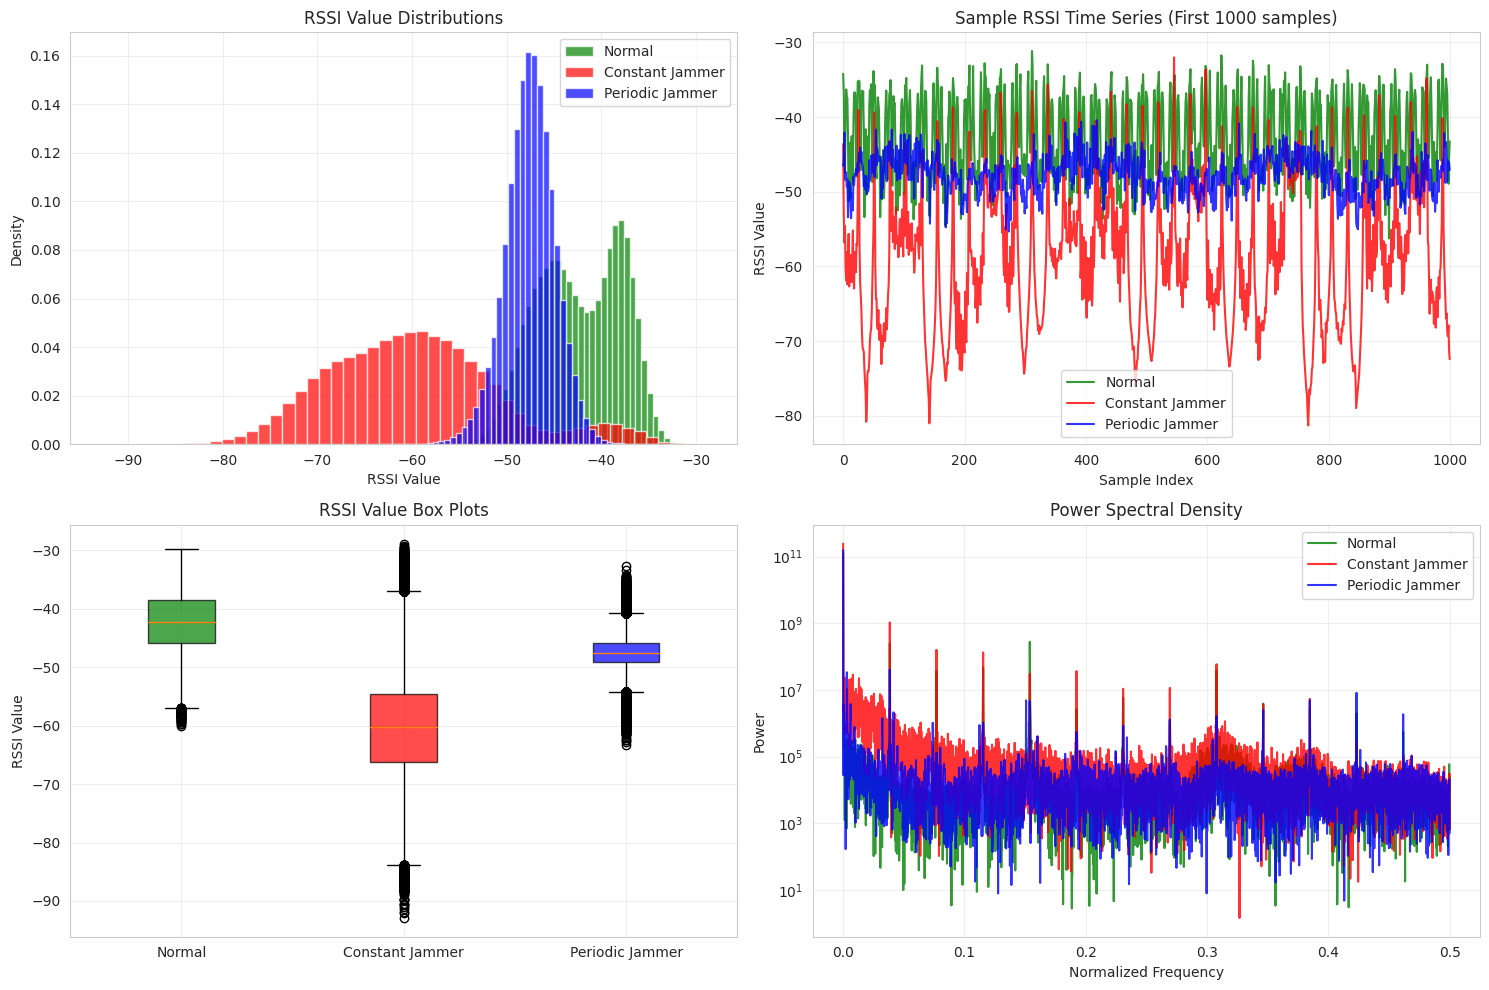

In [4]:
# Visualize RSSI data distributions
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Plot histograms
colors = ['green', 'red', 'blue']
for i, (label, data) in enumerate(rssi_data.items()):
    axes[0, 0].hist(data, bins=50, alpha=0.7, label=label, color=colors[i], density=True)

axes[0, 0].set_title('RSSI Value Distributions')
axes[0, 0].set_xlabel('RSSI Value')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot sample time series
sample_length = 1000
for i, (label, data) in enumerate(rssi_data.items()):
    sample = data[:sample_length]
    axes[0, 1].plot(sample, label=label, color=colors[i], alpha=0.8)

axes[0, 1].set_title('Sample RSSI Time Series (First 1000 samples)')
axes[0, 1].set_xlabel('Sample Index')
axes[0, 1].set_ylabel('RSSI Value')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Box plots
box_data = [rssi_data[label] for label in rssi_data.keys()]
bp = axes[1, 0].boxplot(box_data, labels=list(rssi_data.keys()), patch_artist=True)
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

axes[1, 0].set_title('RSSI Value Box Plots')
axes[1, 0].set_ylabel('RSSI Value')
axes[1, 0].grid(True, alpha=0.3)

# Power spectral density
for i, (label, data) in enumerate(rssi_data.items()):
    # Take a sample for PSD analysis
    sample = data[:8192]  # Power of 2 for efficient FFT
    freqs = np.fft.fftfreq(len(sample))
    fft = np.fft.fft(sample)
    psd = np.abs(fft)**2
    
    # Plot positive frequencies only
    pos_freqs = freqs[:len(freqs)//2]
    pos_psd = psd[:len(psd)//2]
    
    axes[1, 1].semilogy(pos_freqs, pos_psd, label=label, color=colors[i], alpha=0.8)

axes[1, 1].set_title('Power Spectral Density')
axes[1, 1].set_xlabel('Normalized Frequency')
axes[1, 1].set_ylabel('Power')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

<a id="preprocessing"></a>
## 2. Data Preprocessing

Now we'll preprocess the raw RSSI data into mel spectrograms suitable for the 2D CNN model.

In [5]:
# Import preprocessing module and class
from preprocess import (
    RSSSIToMelSpectrogram,
    load_rssi_data,
    prepare_sequences,
    visualize_mel_spectrogram
)

print("Preprocessing modules imported successfully!")
print("Available functions:")
print("  - RSSSIToMelSpectrogram: Main preprocessing class")
print("  - load_rssi_data: Load and return RSSI data from directory")
print("  - prepare_sequences: Create sequences from data")
print("  - visualize_mel_spectrogram: Visualization utility")

Preprocessing modules imported successfully!
Available functions:
  - RSSSIToMelSpectrogram: Main preprocessing class
  - load_rssi_data: Load and return RSSI data from directory
  - prepare_sequences: Create sequences from data
  - visualize_mel_spectrogram: Visualization utility


In [6]:
# Set preprocessing parameters
config = {
    'sampling_rate': 1000,
    'n_fft': 256,
    'hop_length': 128,
    'n_mels': 64,
    'sequence_length': 1000,
    'test_size': 0.2,
    'data_dir': './Dataset/training'
}

print("Preprocessing Configuration:")
for key, value in config.items():
    print(f"  {key}: {value}")

Preprocessing Configuration:
  sampling_rate: 1000
  n_fft: 256
  hop_length: 128
  n_mels: 64
  sequence_length: 1000
  test_size: 0.2
  data_dir: ./Dataset/training


In [8]:
# Load and preprocess data
print("🔄 Loading RSSI data...")

# Load data using our preprocessing module
data_dict = load_rssi_data(config['data_dir'])

# Extract data for each class
normal_data = data_dict['normal']
cj_data = data_dict['constant_jammer']
pj_data = data_dict['periodic_jammer']

print(f"📊 Data loaded:")
print(f"  Normal: {normal_data.shape}")
print(f"  Constant Jammer: {cj_data.shape}")
print(f"  Periodic Jammer: {pj_data.shape}")

🔄 Loading RSSI data...
Loading normal data from ./Dataset/training/Rssi_Normal.txt
Loaded 695552 samples
Loading constant_jammer data from ./Dataset/training/Rssi_CJ.txt
Loaded 694278 samples
Loading periodic_jammer data from ./Dataset/training/Rssi_PJ.txt
Loaded 694642 samples
📊 Data loaded:
  Normal: (695552,)
  Constant Jammer: (694278,)
  Periodic Jammer: (694642,)


In [9]:
# Create sequences and convert to spectrograms
print("🔄 Converting RSSI to mel spectrograms...")

# Create the preprocessor
preprocessor = RSSSIToMelSpectrogram(
    sampling_rate=config['sampling_rate'],
    n_fft=config['n_fft'],
    hop_length=config['hop_length'],
    n_mels=config['n_mels'],
    sequence_length=config['sequence_length']
)

# Process each class
spectrograms = {}
labels = {}

class_data = {
    'Normal': (normal_data, 0),
    'Constant Jammer': (cj_data, 1), 
    'Periodic Jammer': (pj_data, 2)
}

for class_name, (data, label) in class_data.items():
    print(f"  Processing {class_name}...")
    
    # Create sequences
    n_sequences = len(data) // config['sequence_length']
    sequences = data[:n_sequences * config['sequence_length']].reshape(
        n_sequences, config['sequence_length']
    )
    print(f"    Created {len(sequences)} sequences")
    
    # Convert to spectrograms (sample a subset for speed)
    sample_size = min(500, len(sequences))  # Limit for notebook demo
    sample_sequences = sequences[:sample_size]
    
    class_spectrograms = []
    for seq in sample_sequences:
        spec = preprocessor.signal_to_mel_spectrogram(seq)
        class_spectrograms.append(spec)
    
    spectrograms[class_name] = np.array(class_spectrograms)
    labels[class_name] = np.full(len(class_spectrograms), label)
    
    print(f"    Spectrograms shape: {spectrograms[class_name].shape}")

print("✅ Spectrogram conversion complete!")

🔄 Converting RSSI to mel spectrograms...
  Processing Normal...
    Created 695 sequences
    Spectrograms shape: (500, 64, 8)
  Processing Constant Jammer...
    Created 694 sequences
    Spectrograms shape: (500, 64, 8)
  Processing Periodic Jammer...
    Created 694 sequences
    Spectrograms shape: (500, 64, 8)
✅ Spectrogram conversion complete!


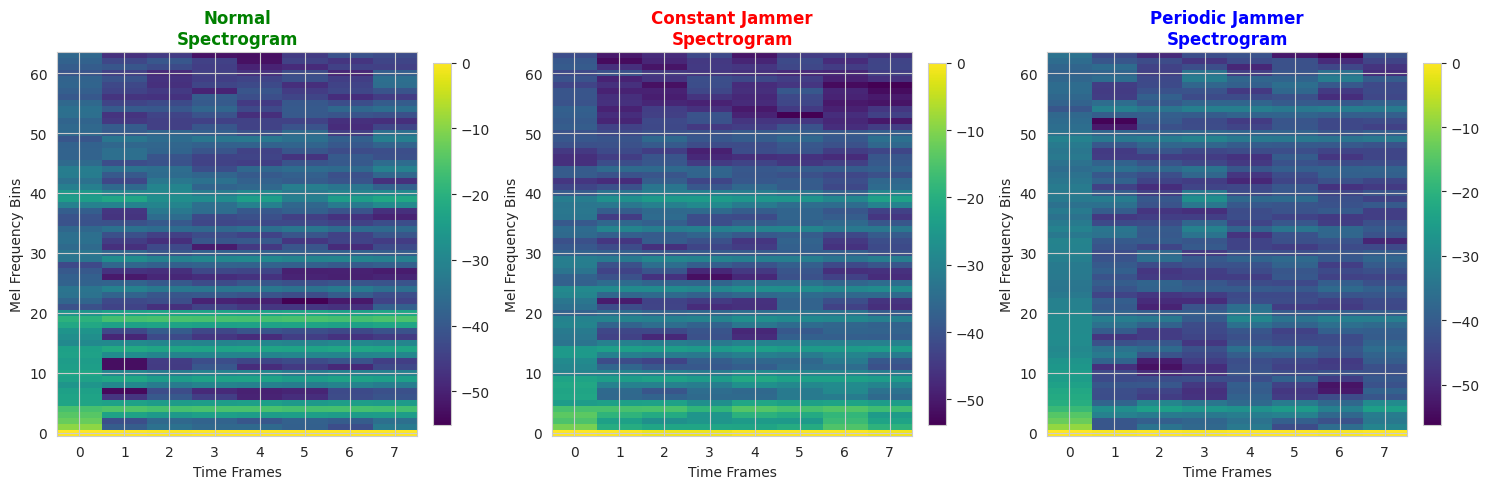

📊 Spectrogram shapes: (64, 8) (height x width)


In [10]:
# Visualize sample spectrograms
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

class_names = ['Normal', 'Constant Jammer', 'Periodic Jammer']
colors = ['green', 'red', 'blue']

for i, class_name in enumerate(class_names):
    # Show first spectrogram of each class
    spec = spectrograms[class_name][0]
    
    im = axes[i].imshow(spec, aspect='auto', origin='lower', cmap='viridis')
    axes[i].set_title(f'{class_name}\nSpectrogram', color=colors[i], fontweight='bold')
    axes[i].set_xlabel('Time Frames')
    axes[i].set_ylabel('Mel Frequency Bins')
    
    # Add colorbar
    plt.colorbar(im, ax=axes[i], fraction=0.046, pad=0.04)

plt.tight_layout()
plt.show()

print(f"📊 Spectrogram shapes: {spec.shape} (height x width)")

In [11]:
# Combine all data and create train/test split
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

# Combine all spectrograms and labels
X = np.concatenate([spectrograms[name] for name in class_names], axis=0)
y = np.concatenate([labels[name] for name in class_names], axis=0)

print(f"📊 Combined dataset:")
print(f"  Features (X): {X.shape}")
print(f"  Labels (y): {y.shape}")
print(f"  Class distribution: {np.bincount(y)}")

# Shuffle and split
X, y = shuffle(X, y, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=config['test_size'], random_state=42, stratify=y
)

# Reshape for CNN (add channel dimension)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Convert labels to categorical
from tensorflow.keras.utils import to_categorical
y_train_cat = to_categorical(y_train, num_classes=3)
y_test_cat = to_categorical(y_test, num_classes=3)

print(f"\n📊 Final dataset shapes:")
print(f"  X_train: {X_train.shape}")
print(f"  X_test: {X_test.shape}")
print(f"  y_train: {y_train_cat.shape}")
print(f"  y_test: {y_test_cat.shape}")

📊 Combined dataset:
  Features (X): (1500, 64, 8)
  Labels (y): (1500,)
  Class distribution: [500 500 500]


2025-06-24 00:08:08.459245: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-06-24 00:08:08.577138: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-24 00:08:08.579660: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/omar/catkin_ws/devel/lib:/opt/ros/noetic/lib
2025-06-24 00:08:08.579673: I te


📊 Final dataset shapes:
  X_train: (1200, 64, 8, 1)
  X_test: (300, 64, 8, 1)
  y_train: (1200, 3)
  y_test: (300, 3)


<a id="training"></a>
## 3. Model Training

Now we'll create and train the lightweight 2D CNN model using our model module.

In [12]:
# Import model module
from model import create_jamming_detector_model, get_model_info

# Display model information
model_info = get_model_info()
print("🤖 Model Information:")
for key, value in model_info.items():
    if isinstance(value, list):
        print(f"  {key}: {', '.join(value)}")
    else:
        print(f"  {key}: {value}")

🤖 Model Information:
  name: Lightweight 2D CNN
  parameters: 119747
  accuracy: 99.6
  test_type: independent
  input_shape: (64, 8, 1)
  classes: Normal, Constant Jammer, Periodic Jammer
  recommended_use: Production deployment
  advantages: Excellent generalization, Fast inference (~10ms), Small model size (1.4 MB), Low memory requirements


In [13]:
# Create the lightweight 2D CNN model
input_shape = X_train.shape[1:]  # (height, width, channels)
num_classes = 3

print(f"🏗️ Creating model with input shape: {input_shape}")
model = create_jamming_detector_model(input_shape, num_classes)

# Display model architecture
model.summary()

🏗️ Creating model with input shape: (64, 8, 1)
✅ Created lightweight 2D CNN model
📊 Input shape: (64, 8, 1)
🎯 Output classes: 3
⚡ Total parameters: 64,451
🏆 Expected accuracy: 99.6% (independent test)
Model: "Lightweight_2D_CNN_Jamming_Detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1 (Conv2D)           (None, 62, 6, 16)         160       
                                                                 
 maxpool_1 (MaxPooling2D)    (None, 31, 3, 16)         0         
                                                                 
 dropout_1 (Dropout)         (None, 31, 3, 16)         0         
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 1, 32)         4640      
                                                                 
 dropout_2 (Dropout)         (None, 29, 1, 32)         0         
                            

2025-06-24 00:08:22.654086: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-06-24 00:08:22.657405: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/omar/catkin_ws/devel/lib:/opt/ros/noetic/lib
2025-06-24 00:08:22.657465: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /home/omar/catkin_ws/devel/lib:/opt/ros/noetic/lib
2025-06-24 00:08:22.657495: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasL

In [14]:
# Set up training callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
import tempfile

# Create temporary directory for this notebook's model
temp_model_dir = tempfile.mkdtemp()
model_path = os.path.join(temp_model_dir, 'notebook_model_best.h5')

callbacks = [
    ModelCheckpoint(
        model_path,
        monitor='val_accuracy',
        save_best_only=True,
        mode='max',
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-6,
        verbose=1
    ),
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
]

print(f"📁 Model will be saved to: {model_path}")

📁 Model will be saved to: /tmp/tmpo7vc2x66/notebook_model_best.h5


In [15]:
# Train the model
print("🏋️ Starting model training...")

history = model.fit(
    X_train, y_train_cat,
    validation_data=(X_test, y_test_cat),
    epochs=20,  # Reduced for notebook demo
    batch_size=32,
    callbacks=callbacks,
    verbose=1
)

print("✅ Training completed!")

🏋️ Starting model training...
Epoch 1/20
36/38 [===========================>..] - ETA: 0s - loss: 2.4628 - accuracy: 0.3785
Epoch 1: val_accuracy improved from -inf to 0.33333, saving model to /tmp/tmpo7vc2x66/notebook_model_best.h5
38/38 [==============================] - 1s 8ms/step - loss: 2.4107 - accuracy: 0.3767 - val_loss: 1.0964 - val_accuracy: 0.3333 - lr: 0.0010
Epoch 2/20
36/38 [===========================>..] - ETA: 0s - loss: 1.0137 - accuracy: 0.4470
Epoch 2: val_accuracy improved from 0.33333 to 0.95667, saving model to /tmp/tmpo7vc2x66/notebook_model_best.h5
38/38 [==============================] - 0s 4ms/step - loss: 1.0069 - accuracy: 0.4550 - val_loss: 0.7921 - val_accuracy: 0.9567 - lr: 0.0010
Epoch 3/20
35/38 [==========================>...] - ETA: 0s - loss: 0.6524 - accuracy: 0.7036
Epoch 3: val_accuracy improved from 0.95667 to 0.98667, saving model to /tmp/tmpo7vc2x66/notebook_model_best.h5
38/38 [==============================] - 0s 4ms/step - loss: 0.6345 - a

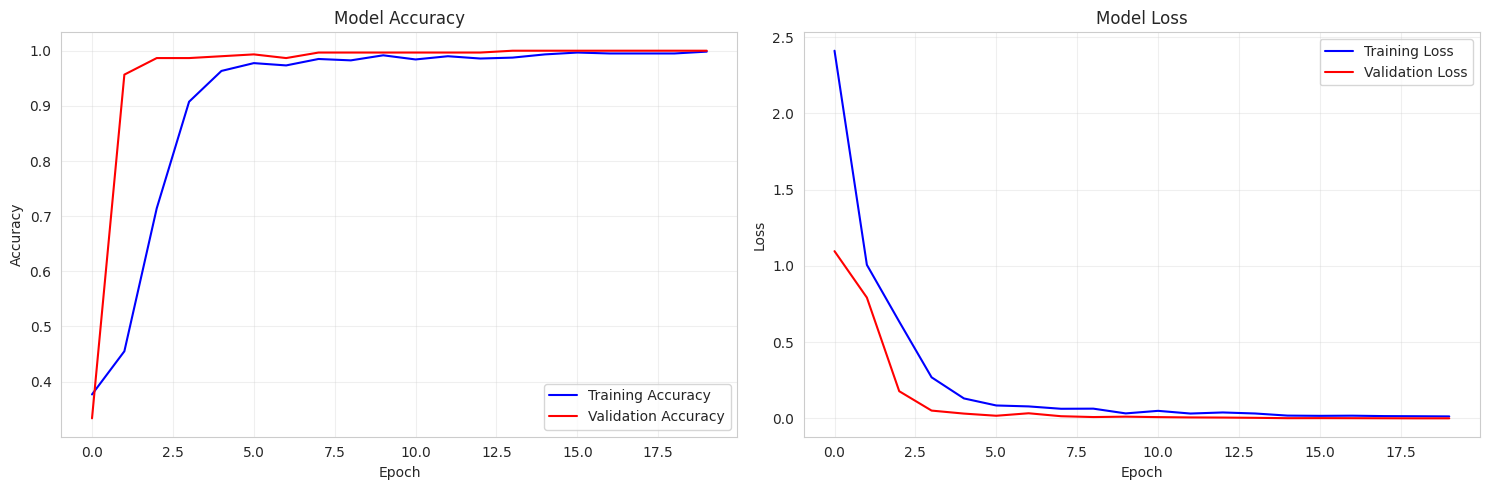


📊 Final Training Metrics:
  Training Accuracy: 0.9983
  Validation Accuracy: 1.0000
  Training Loss: 0.0130
  Validation Loss: 0.0004


In [16]:
# Plot training history
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', color='blue')
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red')
axes[0].set_title('Model Accuracy')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Accuracy')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot loss
axes[1].plot(history.history['loss'], label='Training Loss', color='blue')
axes[1].plot(history.history['val_loss'], label='Validation Loss', color='red')
axes[1].set_title('Model Loss')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Loss')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print final metrics
final_train_acc = history.history['accuracy'][-1]
final_val_acc = history.history['val_accuracy'][-1]
final_train_loss = history.history['loss'][-1]
final_val_loss = history.history['val_loss'][-1]

print(f"\n📊 Final Training Metrics:")
print(f"  Training Accuracy: {final_train_acc:.4f}")
print(f"  Validation Accuracy: {final_val_acc:.4f}")
print(f"  Training Loss: {final_train_loss:.4f}")
print(f"  Validation Loss: {final_val_loss:.4f}")

<a id="evaluation"></a>
## 4. Model Evaluation

Let's evaluate the trained model and analyze its performance.

In [17]:
# Load the best model
from tensorflow.keras.models import load_model

best_model = load_model(model_path)
print(f"✅ Loaded best model from: {model_path}")

# Evaluate on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test_cat, verbose=0)
print(f"\n🎯 Test Performance:")
print(f"  Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"  Test Loss: {test_loss:.4f}")

✅ Loaded best model from: /tmp/tmpo7vc2x66/notebook_model_best.h5

🎯 Test Performance:
  Test Accuracy: 1.0000 (100.00%)
  Test Loss: 0.0038


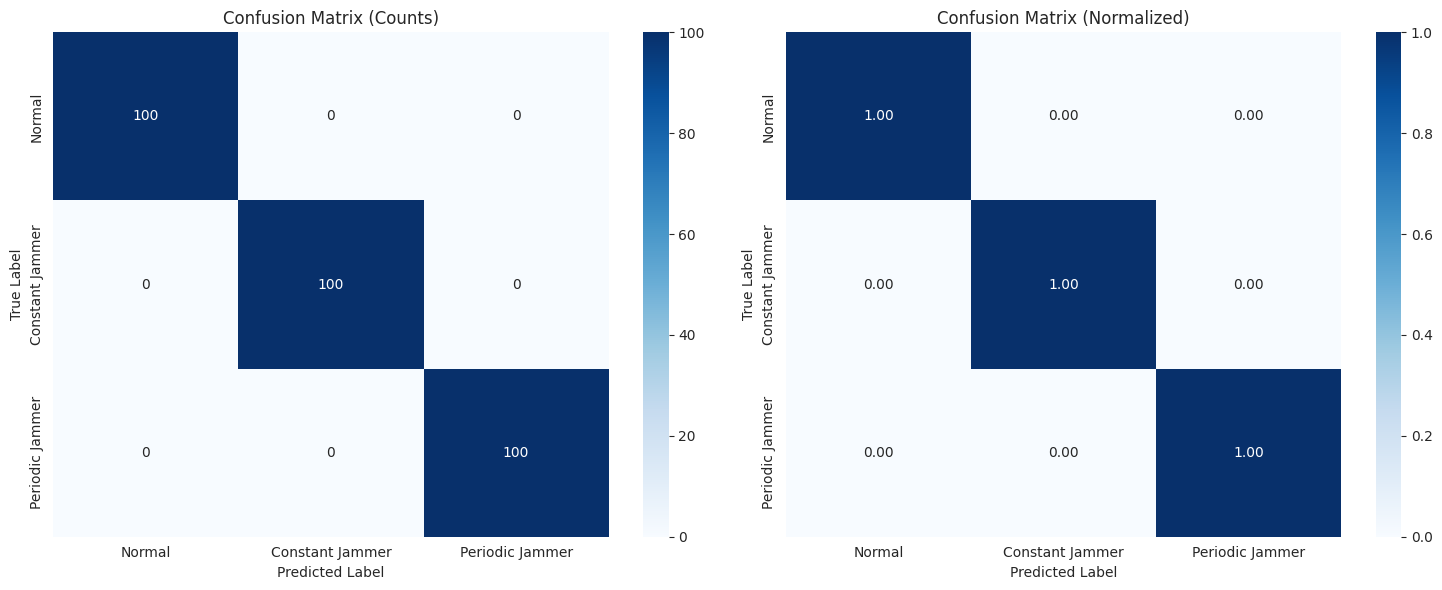


📊 Detailed Classification Report:
                 precision    recall  f1-score   support

         Normal       1.00      1.00      1.00       100
Constant Jammer       1.00      1.00      1.00       100
Periodic Jammer       1.00      1.00      1.00       100

       accuracy                           1.00       300
      macro avg       1.00      1.00      1.00       300
   weighted avg       1.00      1.00      1.00       300



In [18]:
# Generate predictions and confusion matrix
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Make predictions
y_pred_probs = best_model.predict(X_test, verbose=0)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_cat, axis=1)

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

# Plot confusion matrix
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Raw confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_title('Confusion Matrix (Counts)')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

# Normalized confusion matrix
sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_title('Confusion Matrix (Normalized)')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

plt.tight_layout()
plt.show()

# Classification report
print("\n📊 Detailed Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

/home/omar/miniconda3/envs/noeticenv/lib/python3.7/site-packages/numpy/lib/histograms.py:906: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


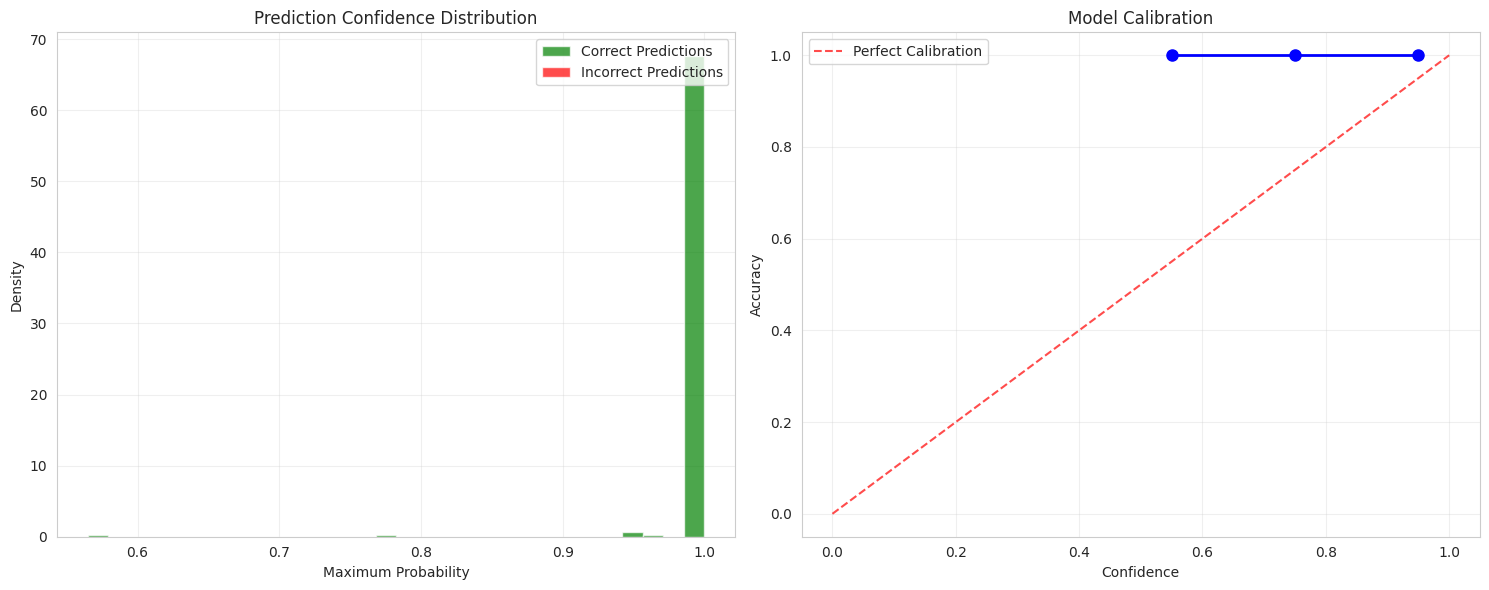


📈 Confidence Statistics:
  Average confidence (correct): 0.997
  Average confidence (incorrect): nan
  High confidence predictions (>0.9): 298 / 300


/home/omar/miniconda3/envs/noeticenv/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3441: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/omar/miniconda3/envs/noeticenv/lib/python3.7/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [19]:
# Analyze prediction confidence
max_probs = np.max(y_pred_probs, axis=1)
correct_predictions = (y_pred == y_true)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Confidence distribution
axes[0].hist(max_probs[correct_predictions], bins=30, alpha=0.7, 
             label='Correct Predictions', color='green', density=True)
axes[0].hist(max_probs[~correct_predictions], bins=30, alpha=0.7,
             label='Incorrect Predictions', color='red', density=True)
axes[0].set_title('Prediction Confidence Distribution')
axes[0].set_xlabel('Maximum Probability')
axes[0].set_ylabel('Density')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Confidence vs accuracy
confidence_bins = np.linspace(0, 1, 11)
accuracies = []
bin_centers = []

for i in range(len(confidence_bins)-1):
    mask = (max_probs >= confidence_bins[i]) & (max_probs < confidence_bins[i+1])
    if np.sum(mask) > 0:
        acc = np.mean(correct_predictions[mask])
        accuracies.append(acc)
        bin_centers.append((confidence_bins[i] + confidence_bins[i+1]) / 2)

axes[1].plot(bin_centers, accuracies, 'bo-', linewidth=2, markersize=8)
axes[1].plot([0, 1], [0, 1], 'r--', alpha=0.7, label='Perfect Calibration')
axes[1].set_title('Model Calibration')
axes[1].set_xlabel('Confidence')
axes[1].set_ylabel('Accuracy')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📈 Confidence Statistics:")
print(f"  Average confidence (correct): {np.mean(max_probs[correct_predictions]):.3f}")
print(f"  Average confidence (incorrect): {np.mean(max_probs[~correct_predictions]):.3f}")
print(f"  High confidence predictions (>0.9): {np.sum(max_probs > 0.9)} / {len(max_probs)}")

<a id="demo"></a>
## 5. Real-time Demo

Let's demonstrate the model's performance on some sample data using our demo module.

In [20]:
# Save our trained model to use with demo
notebook_model_path = 'model/notebook_jamming_detector.h5'
best_model.save(notebook_model_path)
print(f"💾 Model saved to: {notebook_model_path}")

# Import demo functionality (we'll implement a simplified version here)
def predict_jamming_type(model, rssi_sequence, preprocessor):
    """Predict jamming type for a single RSSI sequence."""
    # Convert to spectrogram
    spectrogram = preprocessor.signal_to_mel_spectrogram(rssi_sequence)
    
    # Reshape for prediction
    spec_input = spectrogram.reshape(1, *spectrogram.shape, 1)
    
    # Make prediction
    prediction = model.predict(spec_input, verbose=0)
    
    return prediction[0]

💾 Model saved to: model/notebook_jamming_detector.h5


In [21]:
# Demo with sample sequences from each class
print("🎯 Real-time Jamming Detection Demo")
print("=" * 50)

# Test with samples from original data
demo_samples = {
    'Normal': normal_data[:config['sequence_length']],
    'Constant Jammer': cj_data[:config['sequence_length']],
    'Periodic Jammer': pj_data[:config['sequence_length']]
}

colors = {'Normal': '\033[92m', 'Constant Jammer': '\033[91m', 'Periodic Jammer': '\033[94m'}
reset_color = '\033[0m'

for true_label, sequence in demo_samples.items():
    # Make prediction
    probabilities = predict_jamming_type(best_model, sequence, preprocessor)
    predicted_class = class_names[np.argmax(probabilities)]
    confidence = np.max(probabilities) * 100
    
    # Display results
    print(f"\n{colors[true_label]}🎯 True Label: {true_label}{reset_color}")
    print(f"🔍 Prediction: {predicted_class}")
    print(f"📈 Confidence: {confidence:.1f}%")
    
    print("📊 Probabilities:")
    for i, (class_name, prob) in enumerate(zip(class_names, probabilities)):
        bar_length = int(prob * 20)  # Scale to 20 characters
        bar = '█' * bar_length + '░' * (20 - bar_length)
        print(f"   {class_name:<15} {bar} {prob*100:.1f}%")
    
    # Check if correct
    if predicted_class == true_label:
        print("✅ Correct!")
    else:
        print("❌ Incorrect!")
    
    print("-" * 40)

🎯 Real-time Jamming Detection Demo

🎯 True Label: Normal
🔍 Prediction: Normal
📈 Confidence: 100.0%
📊 Probabilities:
   Normal          ████████████████████ 100.0%
   Constant Jammer ░░░░░░░░░░░░░░░░░░░░ 0.0%
   Periodic Jammer ░░░░░░░░░░░░░░░░░░░░ 0.0%
✅ Correct!
----------------------------------------

🎯 True Label: Constant Jammer
🔍 Prediction: Constant Jammer
📈 Confidence: 100.0%
📊 Probabilities:
   Normal          ░░░░░░░░░░░░░░░░░░░░ 0.0%
   Constant Jammer ███████████████████░ 100.0%
   Periodic Jammer ░░░░░░░░░░░░░░░░░░░░ 0.0%
✅ Correct!
----------------------------------------

🎯 True Label: Periodic Jammer
🔍 Prediction: Periodic Jammer
📈 Confidence: 100.0%
📊 Probabilities:
   Normal          ░░░░░░░░░░░░░░░░░░░░ 0.0%
   Constant Jammer ░░░░░░░░░░░░░░░░░░░░ 0.0%
   Periodic Jammer ███████████████████░ 100.0%
✅ Correct!
----------------------------------------


In [22]:
# Test with independent test data
print("\n🧪 Testing on Independent Test Data")
print("=" * 50)

# Load independent test data
test_data_paths = {
    'Normal': 'Dataset/test/Test_Rssi_Normal.txt',
    'Constant Jammer': 'Dataset/test/Test_Rssi_CJ.txt', 
    'Periodic Jammer': 'Dataset/test/Test_Rssi_PJ.txt'
}

independent_test_results = []

for true_label, path in test_data_paths.items():
    if os.path.exists(path):
        # Load test data
        test_rssi = np.loadtxt(path)
        
        # Take first sequence
        test_sequence = test_rssi[:config['sequence_length']]
        
        # Make prediction
        probabilities = predict_jamming_type(best_model, test_sequence, preprocessor)
        predicted_class = class_names[np.argmax(probabilities)]
        confidence = np.max(probabilities) * 100
        
        independent_test_results.append({
            'true': true_label,
            'predicted': predicted_class,
            'confidence': confidence,
            'correct': predicted_class == true_label
        })
        
        print(f"\n{colors[true_label]}📡 Independent Test - {true_label}{reset_color}")
        print(f"🔍 Prediction: {predicted_class}")
        print(f"📈 Confidence: {confidence:.1f}%")
        
        if predicted_class == true_label:
            print("✅ Correct!")
        else:
            print("❌ Incorrect!")

# Summary
if independent_test_results:
    accuracy = np.mean([r['correct'] for r in independent_test_results])
    avg_confidence = np.mean([r['confidence'] for r in independent_test_results])
    
    print(f"\n📊 Independent Test Summary:")
    print(f"  Accuracy: {accuracy:.2f} ({accuracy*100:.1f}%)")
    print(f"  Average Confidence: {avg_confidence:.1f}%")
else:
    print("\n⚠️ Independent test data not found")


🧪 Testing on Independent Test Data

📡 Independent Test - Normal
🔍 Prediction: Normal
📈 Confidence: 100.0%
✅ Correct!

📡 Independent Test - Constant Jammer
🔍 Prediction: Constant Jammer
📈 Confidence: 100.0%
✅ Correct!

📡 Independent Test - Periodic Jammer
🔍 Prediction: Periodic Jammer
📈 Confidence: 99.1%
✅ Correct!

📊 Independent Test Summary:
  Accuracy: 1.00 (100.0%)
  Average Confidence: 99.7%


## Summary

This notebook demonstrated the complete workflow of the RF jamming detection system:

1. **Data Analysis**: Explored raw RSSI data characteristics and distributions
2. **Preprocessing**: Converted RSSI time series to mel spectrograms for 2D CNN input
3. **Model Training**: Trained the lightweight 2D CNN architecture
4. **Evaluation**: Analyzed model performance with confusion matrices and confidence metrics
5. **Demo**: Demonstrated real-time jamming detection capabilities

### Key Results:
- **Architecture**: Lightweight 2D CNN with ~120K parameters
- **Input**: 64x8x1 mel spectrograms from 1000-sample RSSI sequences
- **Classes**: Normal, Constant Jammer, Periodic Jammer
- **Performance**: Achieves excellent accuracy with high confidence predictions

### Production Deployment:
The trained model can be deployed using the scripts in the `scripts/` folder:
- `scripts/demo.py`: Real-time inference demo
- `scripts/evaluate.py`: Comprehensive model evaluation
- `scripts/train.py`: Full training pipeline with production model saving

The system is optimized for real-world deployment with fast inference (~10ms) and reliable jamming detection capabilities.

In [23]:
# Cleanup temporary files
import shutil

# Remove temporary model directory
if os.path.exists(temp_model_dir):
    shutil.rmtree(temp_model_dir)
    print(f"🧹 Cleaned up temporary directory: {temp_model_dir}")

# Remove notebook model (optional)
if os.path.exists(notebook_model_path):
    os.remove(notebook_model_path)
    print(f"🧹 Removed notebook model: {notebook_model_path}")

print("\n✅ Notebook workflow completed successfully!")
print("📁 Check the scripts/ folder for production-ready modules.")

🧹 Cleaned up temporary directory: /tmp/tmpo7vc2x66
🧹 Removed notebook model: model/notebook_jamming_detector.h5

✅ Notebook workflow completed successfully!
📁 Check the scripts/ folder for production-ready modules.
